### Medical Cost Personal Datasets

This data takes account of the insurance amount paid by individuals on some personal details 


https://www.kaggle.com/datasets/willianoliveiragibin/healthcare-insurance

Content Columns

- age: age of primary beneficiary

- sex: insurance contractor gender, female, male

- bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to    height,objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

- children: Number of children covered by health insurance / Number of dependents

- smoker: Smoking

- region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

- charges: Individual medical costs billed by health insurance

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import joblib
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from urllib.parse import urlparse
import mlflow
import mlflow.sklearn


%matplotlib inline
from pycaret.regression import *
from pycaret.datasets import get_data


import logging

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

In [2]:
#Loading the dataset
df = pd.read_csv('insurance.csv')

In [3]:
#Print the first 5 rows of the dataframe.
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Basic EDA and statistical analysis

In [4]:
## gives information about the data types,columns, null value counts, memory usage etc

df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
## basic statistic details about the data (note only numerical columns would be displayed here unless parameter include="all")
##also always notice the minimum and maximum of a distribution, might tell alot about outliers

df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


In [6]:
df_copy = df.copy(deep = True)
df_copy.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [7]:
df_copy
## showing the count of Nans
print(df_copy.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


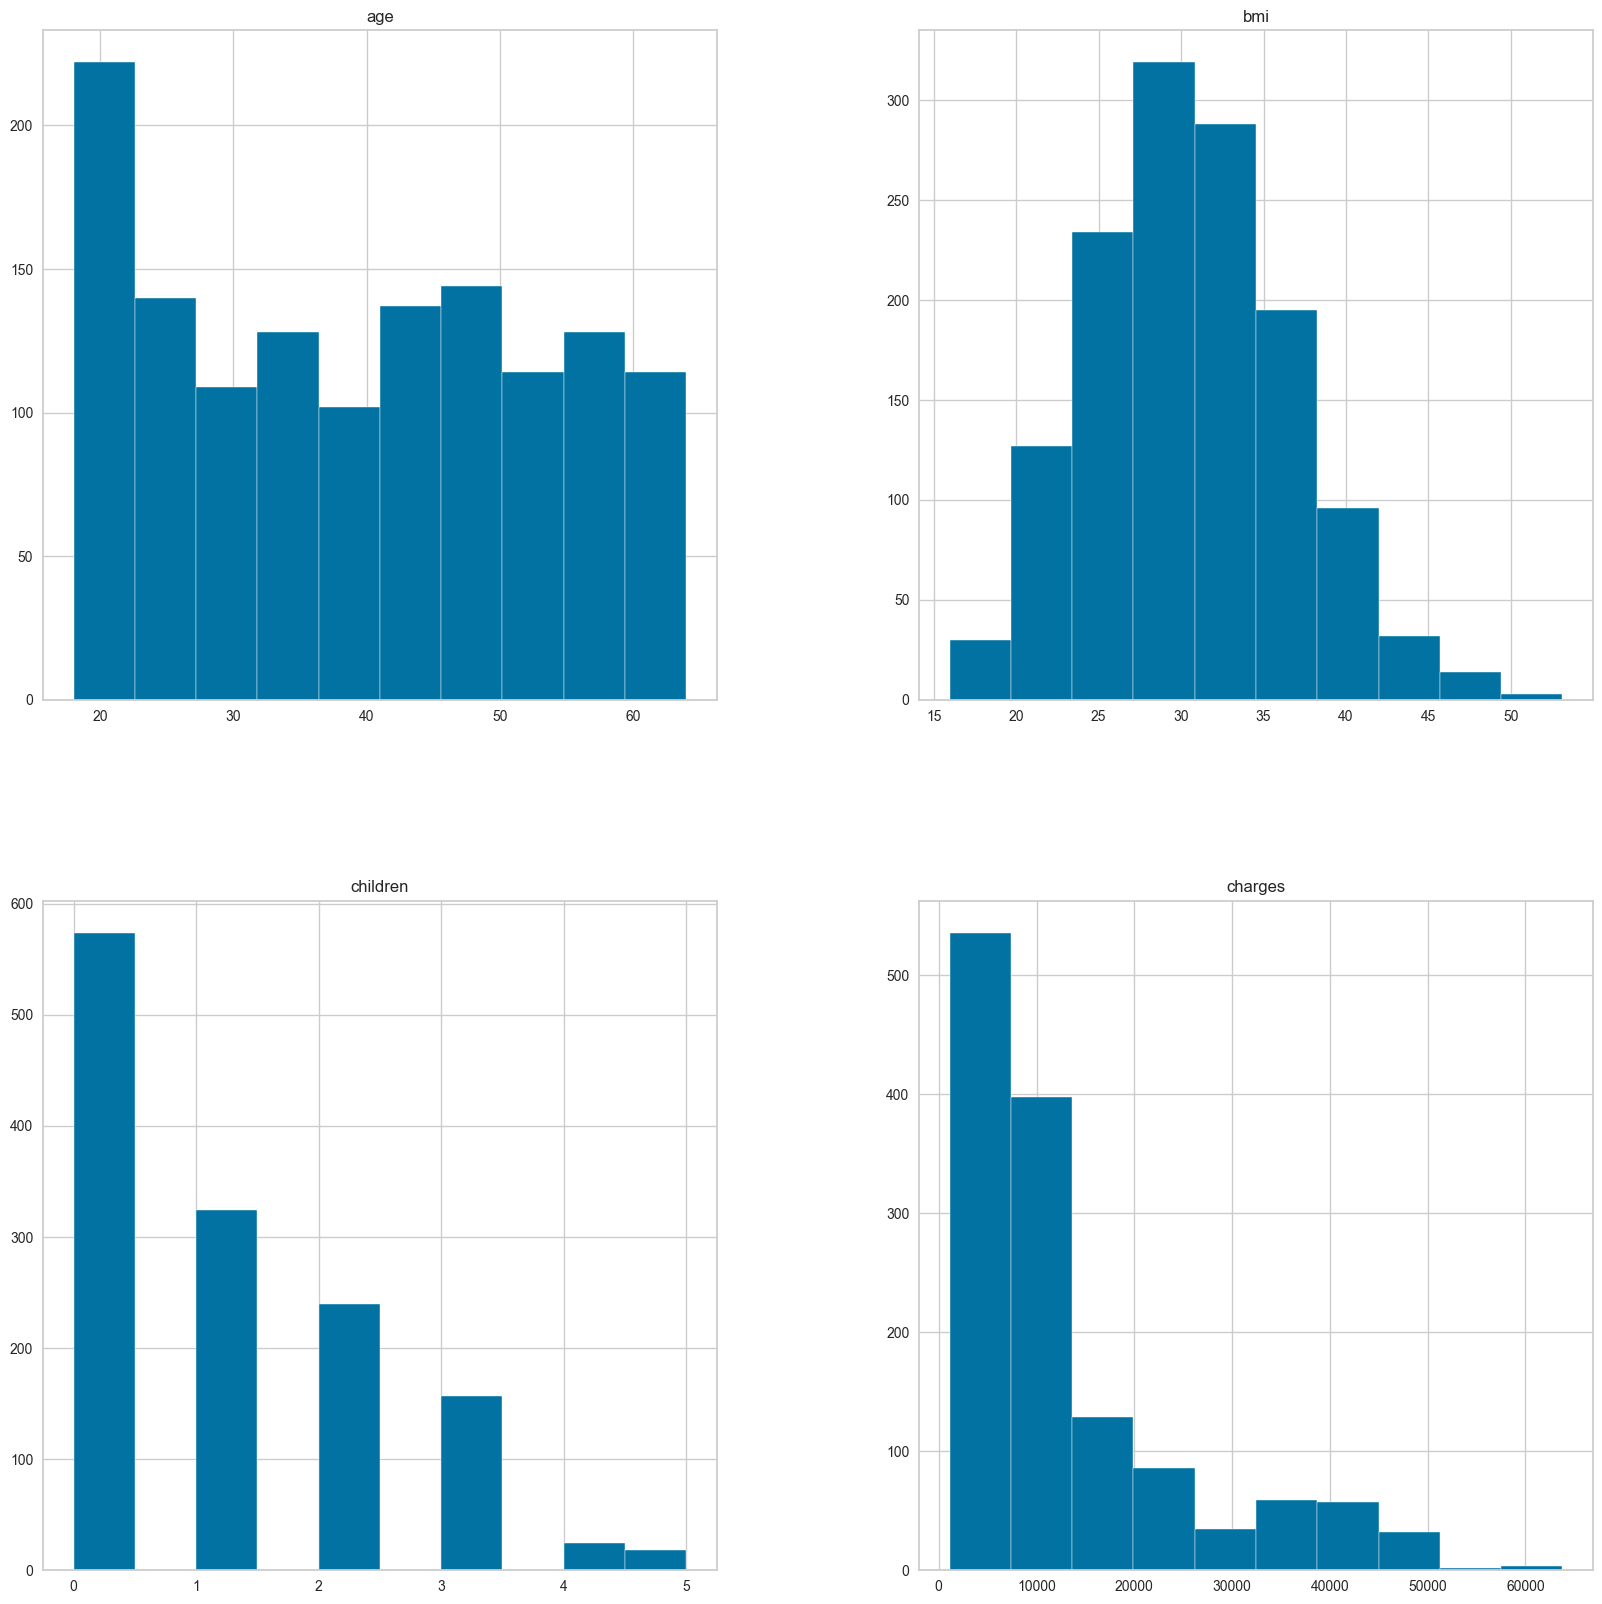

In [8]:
## showing the histogram distribution of the numeric 
p = df_copy.hist(figsize = (20,20))

In [9]:
#pick numeric column to show correlation
df_copy2 = df_copy.select_dtypes(include=['float64', 'int64'])

In [10]:
df_copy2.corr()

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


In [11]:
#correlation of the charge to the other factors
df_copy2.corr()['charges'][:-1]
#age plays a huge role 

age         0.299008
bmi         0.198341
children    0.067998
Name: charges, dtype: float64

<Axes: >

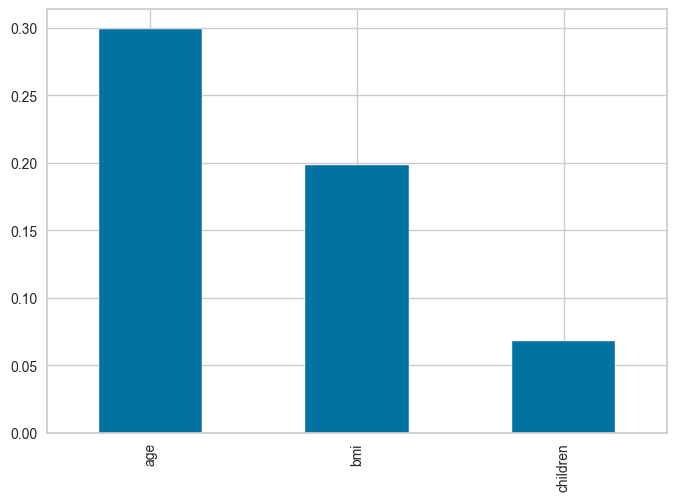

In [12]:
#visual correlation of the charges to the other factors
df_copy2.corr()['charges'][:-1].plot(kind = 'bar')

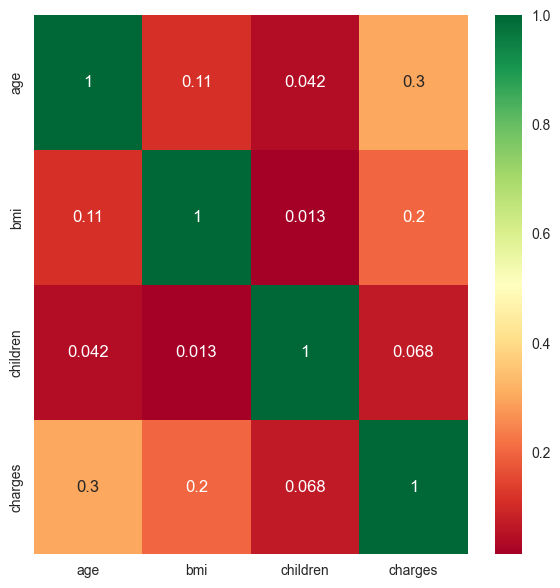

In [13]:
plt.figure(figsize=(7,7))  # on this line I just set the size of figure to 8 by 8.
p=sns.heatmap(df_copy2.corr(), annot=True,cmap ='RdYlGn')  # seaborn  solution for heatmap
#visual display of the coeffeicient correlation between the items


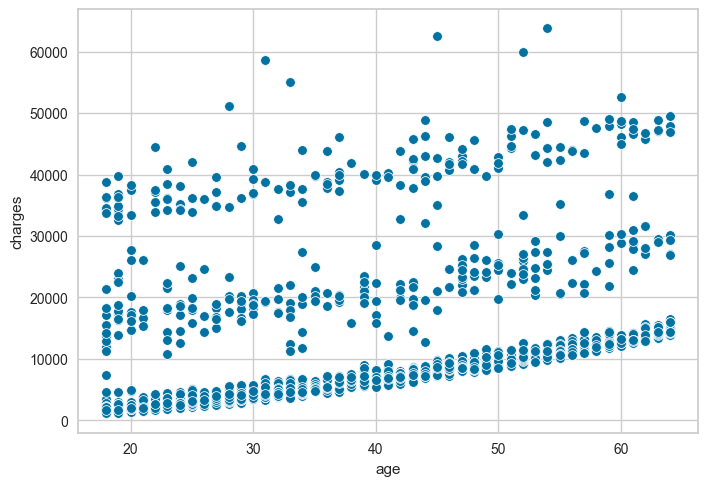

In [14]:
p =sns.scatterplot(df_copy, x = 'age', y = 'charges')

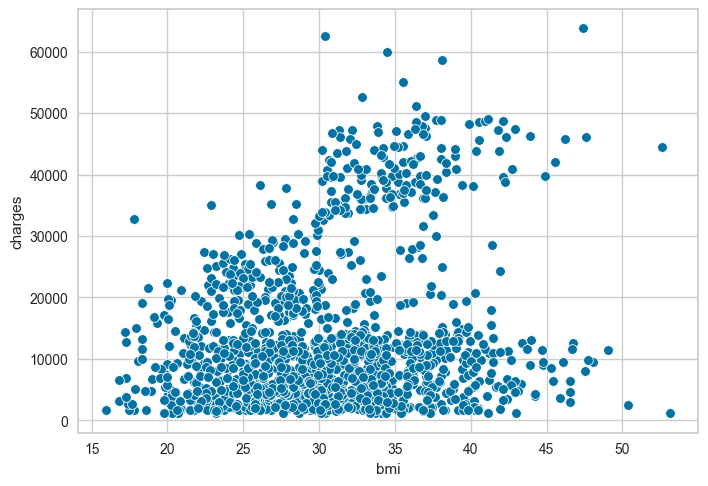

In [15]:
p =sns.scatterplot(df_copy, x = 'bmi', y = 'charges')

<Axes: xlabel='sex', ylabel='count'>

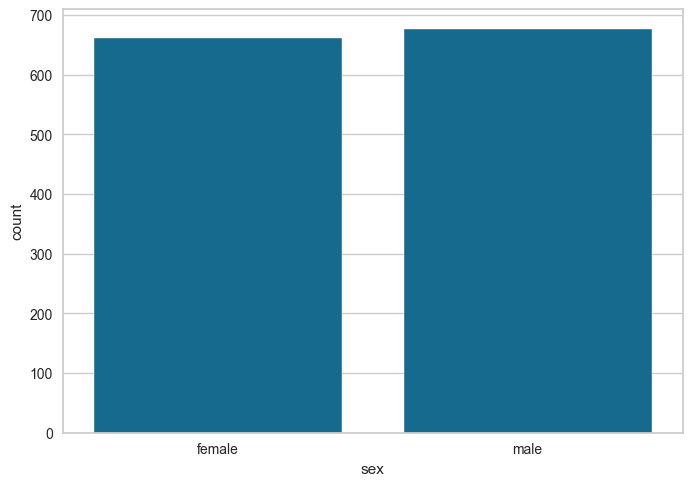

In [16]:
#countplot of the male and female of the amount of peple in the data
sns.countplot(x = 'sex', data = df_copy)

<Axes: xlabel='region', ylabel='count'>

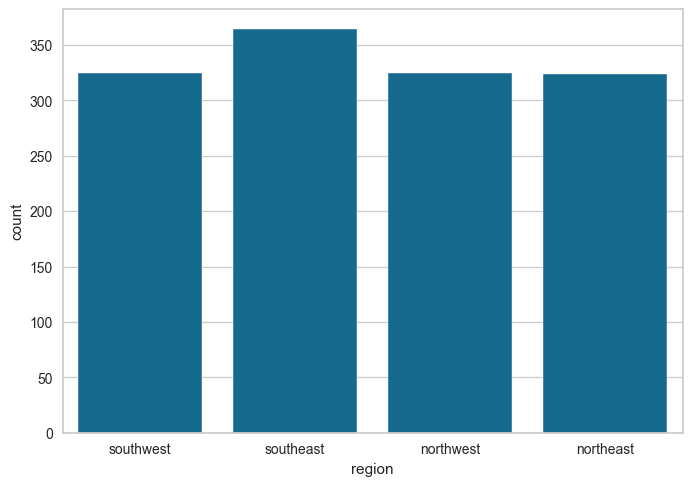

In [17]:
#countplot of the regions in the data
sns.countplot(x = 'region', data =df_copy )

<Axes: xlabel='region', ylabel='count'>

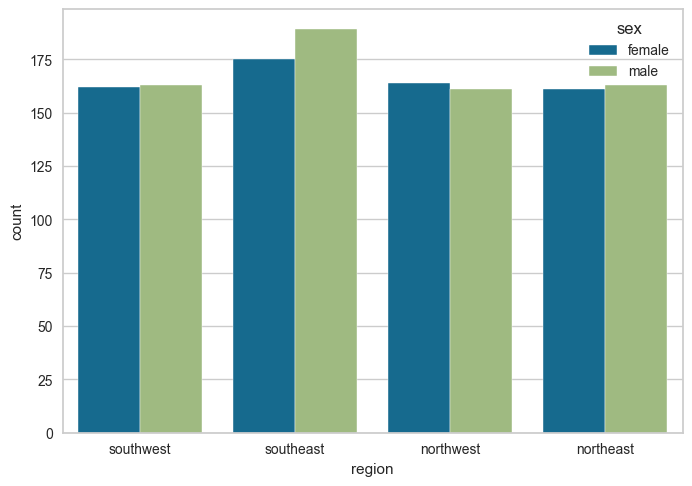

In [18]:
#showing regions with more gender
sns.countplot(x = 'region',hue = 'sex',data = df_copy)

<Axes: xlabel='smoker', ylabel='count'>

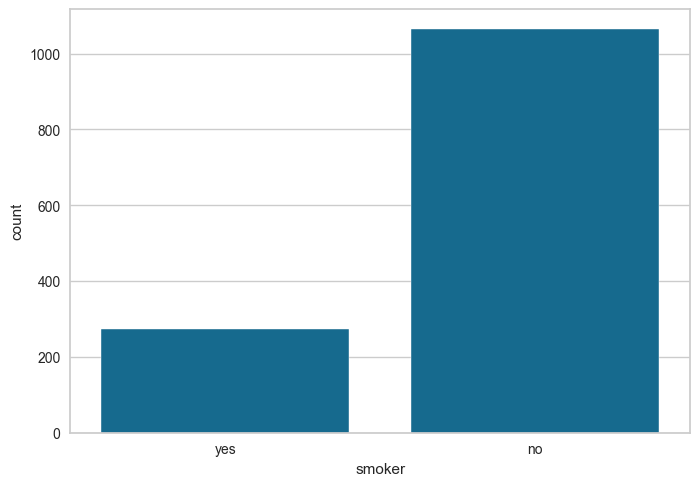

In [19]:
#the amount of smokers
sns.countplot(x = 'smoker', data = df_copy)

<Axes: xlabel='smoker', ylabel='count'>

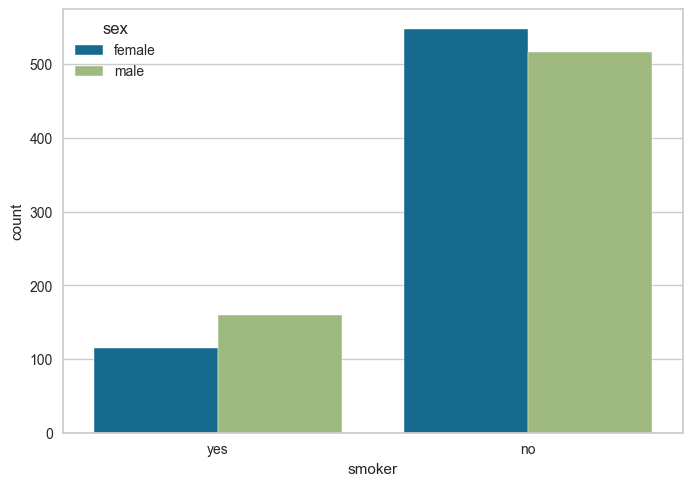

In [20]:
#the gender with high amount of smokers is men
sns.countplot(x = 'smoker', hue = 'sex',data = df_copy)

<Axes: xlabel='sex', ylabel='charges'>

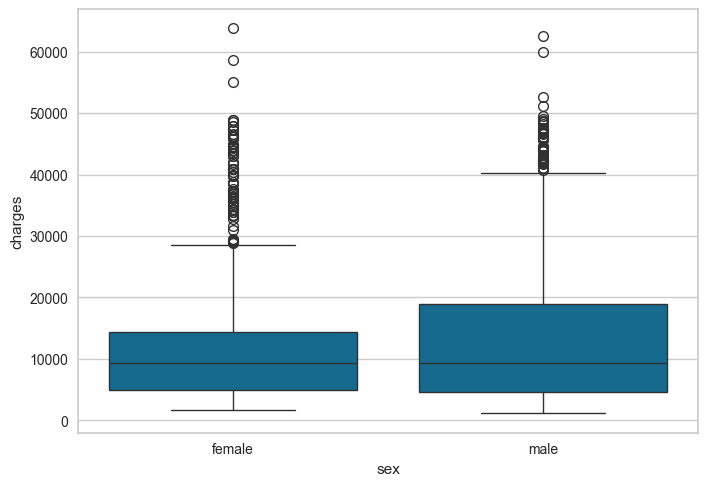

In [21]:
#visualisation of the  charges payed by each gender,
sns.boxplot(x = 'sex', y = 'charges', data = df_copy)

<Axes: xlabel='sex', ylabel='charges'>

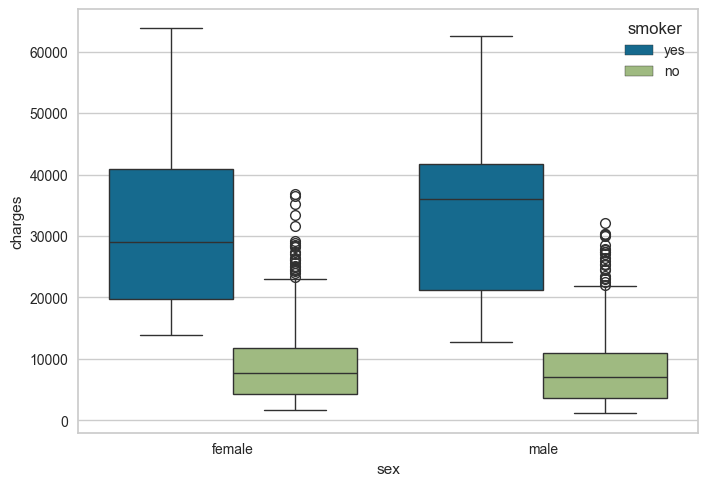

In [22]:
sns.boxplot(x = 'sex', y = 'charges',hue= 'smoker',data = df_copy)
#smokers pay more insurance price than non smokers

## DATA PREPROCESSING


In [23]:
df_copy.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [24]:
# Check for duplicates

duplicates = df.duplicated()

print(f'Number of duplicate rows: {duplicates.sum()}')

Number of duplicate rows: 1


In [25]:
# Optionally, display the duplicate rows
duplicate_rows = df[duplicates]
print(duplicate_rows)

     age   sex    bmi  children smoker     region    charges
581   19  male  30.59         0     no  northwest  1639.5631


In [26]:
# Remove duplicate rows
df_copy = df_copy.drop_duplicates()
df_copy



,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [27]:
df_copy['charges'].sort_values(ascending = False)[:20]

543     63770.42801
1300    62592.87309
1230    60021.39897
577     58571.07448
819     55135.40209
1146    52590.82939
34      51194.55914
1241    49577.66240
1062    48970.24760
488     48885.13561
175     48824.45000
530     48675.51770
901     48673.55880
281     48549.17835
330     48517.56315
39      48173.36100
328     47928.03000
288     47896.79135
55      47496.49445
951     47462.89400
Name: charges, dtype: float64

In [28]:
#values above 50000
df_copy[df_copy['charges'] >= 50000]

,age,sex,bmi,children,smoker,region,charges
34,28,male,36.400,1,yes,southwest,51194.55914
543,54,female,47.410,0,yes,southeast,63770.42801
577,31,female,38.095,1,yes,northeast,58571.07448
819,33,female,35.530,0,yes,northwest,55135.40209
1146,60,male,32.800,0,yes,southwest,52590.82939
1230,52,male,34.485,3,yes,northwest,60021.39897
1300,45,male,30.360,0,yes,southeast,62592.87309


In [29]:
#retrieve index location for prices greater than 50k
x = df_copy[df_copy['charges'] >= 50000].index
df_copy.drop(x, axis = 0, inplace = True)

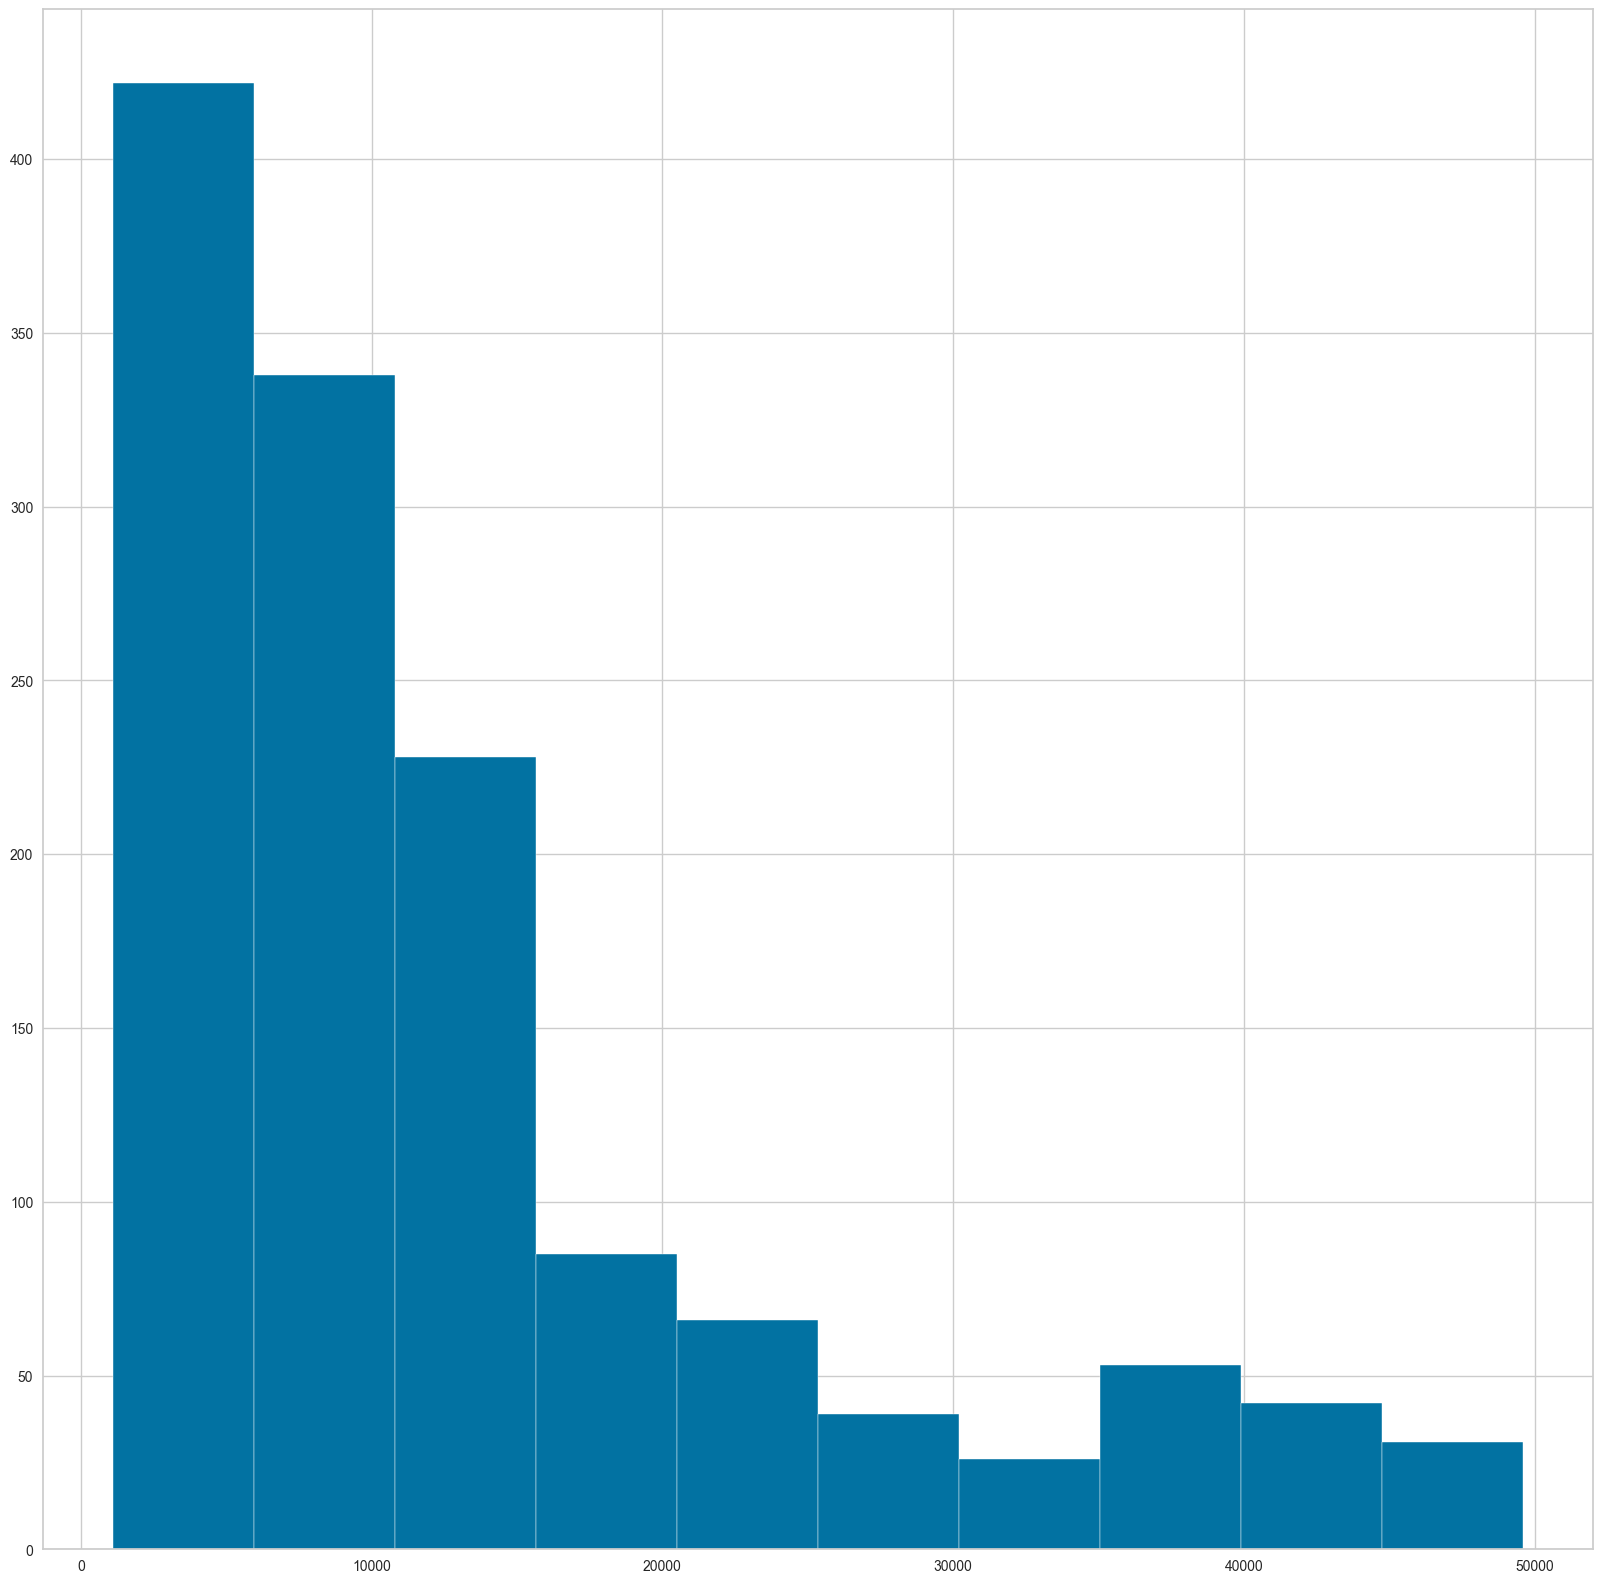

In [30]:
p = df_copy['charges'].hist(figsize = (20,20))

## Data Modelling

Pycaret a python library allows to pick the best algorithim for modelling

In [31]:
df_copy.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [32]:
#split data, into train and test
data = df_copy.sample(frac = 0.75, random_state = 786)  #split data 75,25
data_unseen =  df_copy.drop(data.index)  #drop the data that are present in the data,so they are differe

data.reset_index(drop= True,inplace = True) #srearrange the indexes
data_unseen.reset_index(drop= True,inplace = True)


print('data for modelling :' + str(data.shape))

print('unseen data for predictions :' + str(data_unseen.shape))

data for modelling :(998, 7)
unseen data for predictions :(332, 7)


In [33]:
#load the data into the pycaret set up, normalize the numeric feature and create label encoding for the ordinal feature
from pycaret.regression import setup


reg_setup = setup(data=df_copy, 
                  target='charges', 
                  profile=True, 
                  session_id=123,
                  normalize = True, 
                  ordinal_features = {'sex' : ['female', 'male',], 'smoker': ['yes', 'no']},
                 log_experiment = True,
                  experiment_name = 'price')


,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1330, 7)"
4,Transformed data shape,"(1330, 10)"
5,Transformed train set shape,"(930, 10)"
6,Transformed test set shape,"(400, 10)"
7,Ordinal features,2
8,Numeric features,3
9,Categorical features,3


Loading profile... Please Wait!


In [34]:
#pycaret runs through the data searching for algorithim that fits the data

best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2365.0123,19259520.1658,4303.9403,0.8505,0.3995,0.2676,0.0520
rf,Random Forest Regressor,2395.9397,20485666.5742,4457.7644,0.8411,0.4204,0.2719,0.0870
catboost,CatBoost Regressor,2451.2209,20488939.5419,4462.6311,0.8410,0.4282,0.2808,0.7690
ada,AdaBoost Regressor,3657.1805,23268578.3663,4780.1722,0.8201,0.5633,0.5901,0.0180
et,Extra Trees Regressor,2449.5763,23245150.5353,4759.6465,0.8189,0.4357,0.2741,0.0700
xgboost,Extreme Gradient Boosting,2721.8056,24129790.7000,4860.9407,0.8130,0.4889,0.3328,0.0250
knn,K Neighbors Regressor,3359.6361,29159447.0000,5367.3317,0.7773,0.4558,0.3333,0.0230
br,Bayesian Ridge,4062.4082,34140289.4344,5817.0511,0.7413,0.5442,0.3999,0.0160
lar,Least Angle Regression,4058.6088,34140892.5108,5817.1684,0.7412,0.5463,0.3989,0.0160
llar,Lasso Least Angle Regression,4058.4291,34140235.1649,5817.0983,0.7412,0.5458,0.3989,0.0170


In [35]:
#best model is gradient boost regressor, can further tune 
tuned_best = tune_model(best_model)

#best model is the original model without hyperparameter tuning

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2678.8327,20387641.5463,4515.2676,0.8874,0.6183,0.4118
1,2857.6779,23245951.3047,4821.4055,0.8127,0.8680,0.3543
2,2999.9363,21972630.5441,4687.4973,0.8405,0.5718,0.3256
3,3125.2233,25638008.8419,5063.3989,0.7706,0.6715,0.4770
4,2877.4535,23961360.7636,4895.0343,0.8075,0.4976,0.3224
5,2156.6875,10889687.7061,3299.9527,0.9332,0.5017,0.3380
6,2714.1252,20967468.7509,4579.0249,0.8006,0.5772,0.3553
7,2984.9804,25615860.5489,5061.2114,0.8093,0.4409,0.3410
8,3704.7117,31773692.2850,5636.8158,0.7080,0.5852,0.4586


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


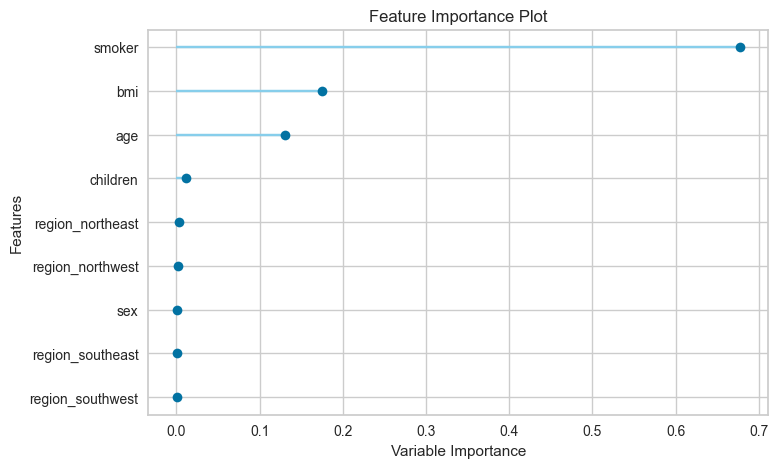

In [36]:
#show the feature importance on the algorithim 
plot_model(tuned_best,plot = 'feature')

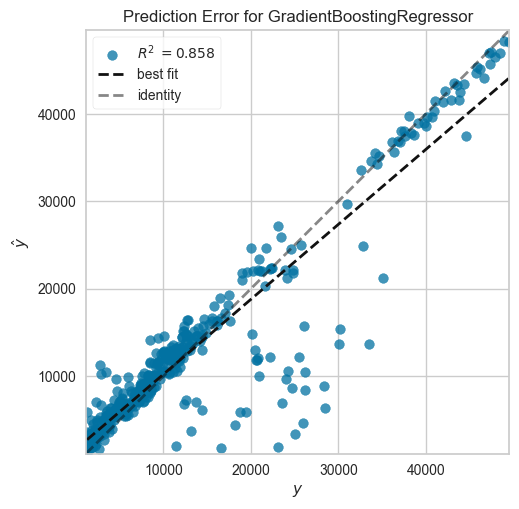

In [37]:
#best model on the evaluation data
plot_model(tuned_best, plot = 'error')

In [38]:
#show details of the best model
evaluate_model(tuned_best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [39]:
#model training on the evaluation data  
predict_model(tuned_best);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,2361.7613,19923616.1501,4463.5878,0.8583,0.4363,0.2792


In [40]:
#model training on the RESERVED data  

unseen_data = predict_model(tuned_best, data = data_unseen)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,1653.7589,9761275.4819,3124.3040,0.9327,0.3225,0.2295


In [41]:
unseen_data.head()

,age,sex,bmi,children,smoker,region,charges,prediction_label
0,33,male,22.705000,0,no,northwest,21984.470703,7139.400946
1,31,female,25.740000,0,no,southeast,3756.621582,4217.161496
2,37,female,27.740000,3,no,northwest,7281.505371,7447.647924
3,62,female,26.290001,0,yes,southeast,27808.724609,28349.285142
4,23,male,34.400002,0,no,southwest,1826.843018,3319.981238


## Scikit Learn and MlFlow for data modelling and production

In [42]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor


In [43]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,23,male,31.73,3,yes,northeast,36189.1017
1,34,female,27.72,0,no,southeast,4415.1588
2,44,female,23.98,2,no,southeast,8211.1002
3,19,male,35.40,0,no,southwest,1263.2490
4,19,female,34.70,2,yes,southwest,36397.5760


In [44]:
data_unseen.head()

,age,sex,bmi,children,smoker,region,charges
0,33,male,22.705,0,no,northwest,21984.47061
1,31,female,25.740,0,no,southeast,3756.62160
2,37,female,27.740,3,no,northwest,7281.50560
3,62,female,26.290,0,yes,southeast,27808.72510
4,23,male,34.400,0,no,southwest,1826.84300


In [45]:
# Split the data into features and target
X_train = data.drop('charges', axis=1)
y_train = data ['charges']
X_test = data_unseen.drop('charges', axis=1)
y_test = data_unseen['charges']

In [46]:
# Define column names
numeric_features = ['age', 'bmi', 'children']
categorical_features = ['sex', 'smoker', 'region']

In [47]:
# Preprocessing for numerical data
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first'))  # drop='first' to avoid dummy variable trap
])

In [48]:
# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the preprocessing and training pipeline
# Initialize the Gradient Boosting Regressor
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('gbr',GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=123))
])

In [49]:
# Fit the model
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('gbr', GradientBoostingRegressor(random_state=123))])

In [50]:
# Predict on the test set
y_pred = model_pipeline.predict(X_test)

In [51]:
from sklearn import metrics
print('mean_absolute_error: ' ,metrics.mean_absolute_error(y_test,y_pred))
print( 'mean_squared_error: ', metrics.mean_squared_error(y_test,y_pred))
print('root_mean_squared_error: ', np.sqrt(metrics.mean_squared_error(y_test,y_pred)))
print('R2:' , metrics.r2_score(y_test, y_pred))

mean_absolute_error:  2254.094975026396
mean_squared_error:  14548806.279807959
root_mean_squared_error:  3814.2897477522547
R2: 0.8997403182415062


In [52]:
# Save the model pipeline
joblib.dump(model_pipeline, 'model_pipeline.joblib')

['model_pipeline.joblib']

In [59]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import mlflow
import mlflow.sklearn
from urllib.parse import urlparse
import warnings

# Load your data (assuming data and data_unseen are already loaded in your script)
# data = pd.read_csv('path_to_your_data.csv')
# data_unseen = pd.read_csv('path_to_your_unseen_data.csv')

# Example data setup, replace it with actual data loading if necessary
# data = pd.read_csv('path_to_your_data.csv')
# data_unseen = pd.read_csv('path_to_your_unseen_data.csv')

if __name__ == "__main__":
    warnings.filterwarnings("ignore")
    
    # Split the data into features and target
    X_train = data.drop('charges', axis=1)
    y_train = data['charges']
    X_test = data_unseen.drop('charges', axis=1)
    y_test = data_unseen['charges']
    
    # Define column names
    numeric_features = ['age', 'bmi', 'children']
    categorical_features = ['sex', 'smoker', 'region']
    
    # Preprocessing for numerical data
    numeric_transformer = Pipeline(steps=[
        ('scaler', MinMaxScaler())
    ])

    # Preprocessing for categorical data
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(drop='first'))  # drop='first' to avoid dummy variable trap
    ])
    
    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    mlflow.set_tracking_uri(uri="")
    
    print("The set tracking uri is ", mlflow.get_tracking_uri())
    
    # Parameters for Gradient Boosting Regressor
    n_estimators = 100
    learning_rate = 0.1
    max_depth = 3
    
    # End any existing MLflow runs
    if mlflow.active_run():
        mlflow.end_run()
    
    # Start a new MLflow run
    with mlflow.start_run():
    
        # Create the pipeline
        model_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('gbr', GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=123))
        ])
        
        # Fit the pipeline to the training data
        model_pipeline.fit(X_train, y_train)
        
        # Predict on the test set
        y_pred = model_pipeline.predict(X_test)
        
        # Evaluate the model
        mean_abs_error = mean_absolute_error(y_test, y_pred)
        mean_sq_error = mean_squared_error(y_test, y_pred)
        root_mean_sq_error = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        
        print("GradientBoostingRegressor (n_estimators=%f, learning_rate=%f, max_depth=%f):" % (n_estimators, learning_rate, max_depth))
        print('Mean Absolute Error: ', mean_abs_error)
        print('Mean Squared Error: ', mean_sq_error)
        print('Root Mean Squared Error: ', root_mean_sq_error)
        print('R2: ', r2)
        
        # Log parameters and metrics to MLflow
        
        params ={
        "n_estimators": n_estimators,
        "learning_rate": learning_rate,
        "max_depth":max_depth
            
        }
        mlflow.log_params(params)
        
        metrics = {
        "mean_absolute_error":mean_abs_error,
        "mean_squared_error":mean_sq_error,
        "root_mean_squared_error":root_mean_sq_error,
        "R2" : r2
        }
        
        mlflow.log_metrics(metrics)
        
        mlflow.sklearn.log_model(model_pipeline, "Insurance_charge")

        

        
            
            
        mlflow.end_run()


The set tracking uri is  
GradientBoostingRegressor (n_estimators=100.000000, learning_rate=0.100000, max_depth=3.000000):
Mean Absolute Error:  2254.094975026396
Mean Squared Error:  14548806.279807959
Root Mean Squared Error:  3814.2897477522547
R2:  0.8997403182415062
